In [ ]:
pip install git+https://github.com/georgette-femerling/Dtest

In [92]:
import moments
import Dtest
import tskit
import msprime
import demes,demesdraw
import numpy as np

## 1. Building a demographic model

### 1.1 How to build a bubble model

In [ ]:
# model parameters
N = 20e3
split_duration = 1e4
merge_duration = 1e4
a = 0.7 # Split proportions
b = 0.3 # Contribution to merger

bubble = Dtest.bubble_model(
    Nanc = N,
    alpha = [a,1-a],
    beta = [b,1-b],
    split_duration = split_duration,
    merge_duration = merge_duration,
    time_units="years", # default is years, can be years or generations
    generation_time=29 # default is 29ys, defaults to 1 when units == generations
)

You can visualize it with demesdraw

<Axes: ylabel='time ago (years)'>

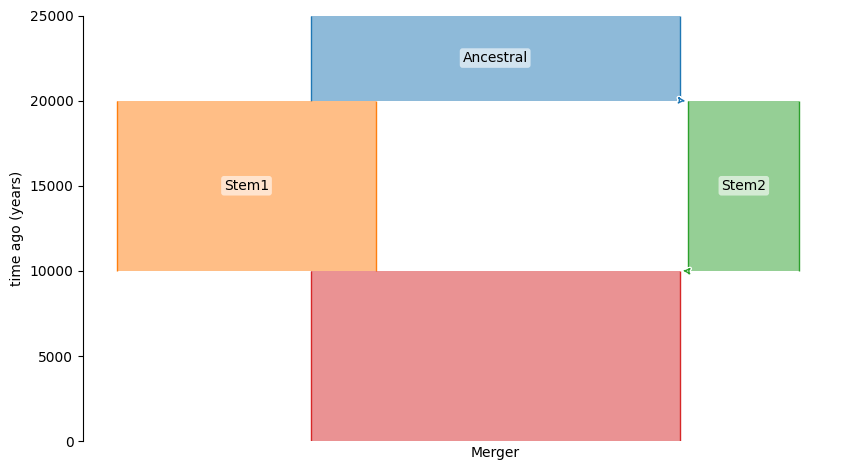

In [10]:
demesdraw.tubes(bubble,log_time=False)

### 1.2 Load DEMES models from YAML

In [11]:
mws_model = Dtest.load_yaml("yaml_pop_models/merger_with_stem_migration.yaml")

<Axes: ylabel='time ago (years)'>

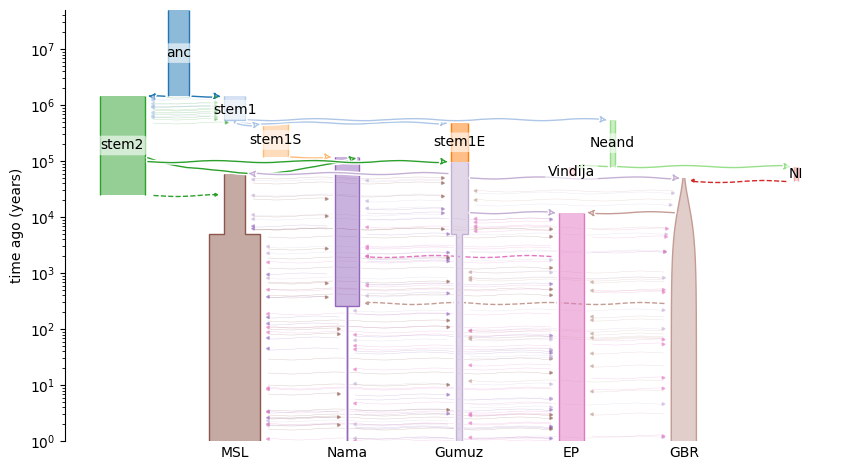

In [13]:
demesdraw.tubes(mws_model,log_time=True)

## 2. Simulating a demographic model using msprime

In [ ]:
# convert to an msprime Demography
bubble_ms = msprime.Demography.from_demes(bubble)
bubble_ms.debug()

### 1.1 Simulate one chr with a constant recombination rate

Simulate one chr of length 1MB for 10 individuals. No replicates

In [ ]:
# parameters of simulation
recom_rate = 1e-8
mutation_rate = 1.25e-8
L = 1e6

ts = msprime.sim_ancestry(
        samples = {'Merger': 10}, #specify from which pop(s) to sample from
        demography=bubble_ms,
        sequence_length=L,
        recombination_rate=recom_rate
)

ts

To save a tree sequence object you can use ts.dump and load it with ts.load()

In [101]:
ts.dump("my_tree_sequence.trees")

In [102]:
ts.load("my_tree_sequence.trees")

If you need to add neutral variation, we need to mutate:

In [ ]:
mutated_ts = msprime.sim_mutations(ts, rate=mutation_rate)
mutated_ts

### 1.2 Simulate a chr with a recombination map

You can simulate each chr in the genome independently 

In [ ]:
# Read recombination map
recmap = msprime.RateMap.read_hapmap("recombination_maps/Hapmap_hg38/per_chr/hapmap_hg38_chr22.txt")

In [ ]:
ts_chr22 = msprime.sim_ancestry(
        samples = {'Merger': 10}, #specify from which pop(s) to sample from
        demography=bubble_ms,
        recombination_rate=recmap
        # no need to specify length as it will be taken from the recombination map      
        )

In [ ]:
ts_chr22

### 1.3 Simulate a complex demography

It is the same as when using the bubble!

In [138]:
mws_model_ms = msprime.Demography.from_demes(mws_model)

In [142]:
# parameters of simulation
recom_rate = 1e-8
mutation_rate = 1.25e-8
L = 1e6

ts_mws = msprime.sim_ancestry(
        samples = {'GBR': 10, 'MSL': 10}, #specify from which pop(s) to sample from
        demography=mws_model_ms,
        sequence_length=L,
        recombination_rate=recom_rate
)

ts_mws

## 2. Replicates

You can get replicates of the simulation, it will result in a generator object

In [145]:
def sim_replicates(samples, demog, reps=100, L=50e6, r=1e-8, u=1.25e-8, mutate=False):
    # Simulate the ancestry
    demog_reps = msprime.sim_ancestry(
        samples,
        demography=demog,
        sequence_length=L,
        recombination_rate=r,
        num_replicates=reps)
    
    # Add neutral mutations 
    if mutate:
        for ts in demog_reps:
            mutated_ts = msprime.sim_mutations(ts, rate=u)
            yield mutated_ts

    # If no mutation, just return the reps
    else:
        return demog_reps

In [ ]:
ts_100 = sim_replicates(samples = {'Merger': 10},
                        demog = bubble_ms
                        )

<generator object Simulator.run_replicates at 0x7fb4ee1d6b00>

In [150]:
next(ts_100)

## 3. Get TMRCA from a tree sequence

When you have a TS, you can get the TMRCA for any two nodes with .tmcra()

In [47]:
ts.first().tmrca(0,1)

11561.241802453487

To get the average TMRCA along the chr for two random samples:

In [97]:
sample_a = np.random.choice(ts.samples(), size=1)[0]
sample_b = np.random.choice(ts.samples(), size=1)[0]
av_tMRCA = 0
for tree in ts.trees():
    # weight the tMRCA by the span of genome covered
    av_tMRCA += tree.tmrca(sample_a, sample_b) * tree.span/ts.sequence_length
print(f"Average tMRCA between sample {sample_a} and",
      f"{sample_b} is {av_tMRCA:.2f} {ts.time_units}")

Average tMRCA between sample 16 and 7 is 43561.60 generations


Or you can get the tmrca at each tree

In [134]:
sample_a = np.random.choice(ts.samples(), size=1)[0]
sample_b = np.random.choice(ts.samples(), size=1)[0]

tMRCA_dict = {}
for tree in ts.trees():
    tMRCA_dict[tree.interval.right] = tree.tmrca(sample_a, sample_b)

Text(0.5, 1.0, 'Data from Dictionary')

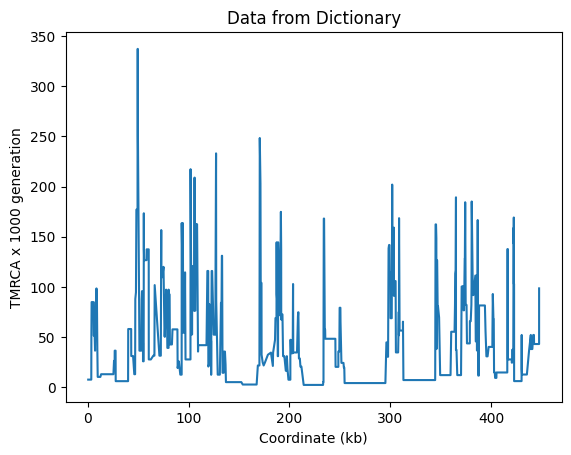

In [135]:
x = np.array(list(tMRCA_dict.keys()))[0:1000]
y = np.array(list(tMRCA_dict.values()))[0:1000]

plt.plot(np.divide(x,1000),np.divide(y,1000))
plt.xlabel("Coordinate (kb)")
plt.ylabel("TMRCA x 1000 generation")
plt.title("Data from Dictionary")
